# Permutation-invariant model

In [1]:
import numpy as np
from scipy.integrate import quad
from scipy.special import gammaln
from scipy.optimize import minimize_scalar
import math

class SyntheticJets:
    def __init__(
        self,
        shape_param=1.0,   # k hyper-param in Gamma(beta|k) prior
        scale_param=1.0,   # Sigma hyper-param in N(phi|0,Sigma) prior
        tokenize=False,    # True: tokenized constituents
        z_order=False,     # True: canonically ordered
        bins_z=None,       # bins for tokenization
        bins_phi=None,     # bins for tokenization
    ):
        self.shape = shape_param
        self.scale = scale_param
        self.tokenize = tokenize
        self.z_order = z_order

        if tokenize:
            self.bins_z = bins_z
            self.bins_phi = bins_phi
            self.num_z_bins = len(self.bins_z) - 1

    def sample(self, N, num_constituents=30):
        samples = (
            np.zeros((N, num_constituents, 2))
            if not self.tokenize
            else np.zeros((N, num_constituents), dtype=int)
        )

        for i in range(N):
            beta = np.random.gamma(shape=self.shape)   
            # mean = np.random.normal(loc=0.0, scale=self.scale)

            event_points = np.zeros((num_constituents, 2))

            for j in range(num_constituents):
                z = np.random.beta(0.5, 1 + beta)
                phi = np.random.normal(loc=self.scale * z - beta, scale=z)
                event_points[j, :] = [z, phi]

            if self.z_order:
                event_points = event_points[np.argsort(event_points[:, 0])][::-1]

            if self.tokenize:
                for j in range(num_constituents):
                    z, phi = event_points[j, :]
                    z_bin = np.digitize(z, self.bins_z) - 1
                    phi_bin = np.digitize(phi, self.bins_phi) - 1
                    z_bin = np.clip(z_bin, 0, len(self.bins_z) - 2)
                    phi_bin = np.clip(phi_bin, 0, len(self.bins_phi) - 2)
                    token = phi_bin * self.num_z_bins + z_bin
                    samples[i, j] = token
            else:
                samples[i, :, 0] = event_points[:, 0]
                samples[i, :, 1] = event_points[:, 1]

        return samples

    def log_prob(self, sample, alpha=0.5):
        """
        sample: shape (N, D, 2)
        returns array of length N of log‐prob per jet.
        """
        Sigma = self.scale
        k = self.shape
        return np.array([self._log_likelihood(sample[i], k, Sigma, alpha)
                        for i in range(len(sample))])

    def tokens_to_bins(self, tokenized_sample):
        # Compute the individual bin indices.
        z_bin = tokenized_sample % self.num_z_bins
        phi_bin = tokenized_sample // self.num_z_bins
        z_bin = np.clip(z_bin, 0, len(self.bins_z) - 2)
        phi_bin = np.clip(phi_bin, 0, len(self.bins_phi) - 2)
        z_center = (self.bins_z[z_bin] + self.bins_z[z_bin + 1]) / 2
        phi_center = (self.bins_phi[phi_bin] + self.bins_phi[phi_bin + 1]) / 2
        return np.stack((z_center, phi_center), axis=-1)


    def log_probs(self, sample, alpha=0.5):
            """
            sample: shape (N, D, 2)
            returns array of length N of log‐prob per jet.
            """
            k = self.shape
            scale = self.scale
            return np.array([
                self._log_likelihood(sample[i], k, scale, alpha)
                for i in range(len(sample))
            ])

    def _log_likelihood(self, sample, k, scale, alpha=0.5):
        """
        Jet log‐likelihood with z,phi and latent beta integrated out.
        sample:      array of shape (D,2), columns = [z, phi]
        k:           Gamma prior shape on beta
        scale:       the 'scale' hyper‑parameter
        alpha:       Beta prior first shape
        """
        z = sample[:, 0]
        phi = sample[:, 1]
        D = len(z)

        sum_log_z   = np.sum(np.log(z))
        sum_log_1mz = np.sum(np.log(1 - z))
        log_gamma_k = gammaln(k)

        def integrand(beta):
            log_p_beta = (k - 1) * np.log(beta) - beta - log_gamma_k
            A = gammaln(alpha + 1 + beta) - gammaln(alpha) - gammaln(1 + beta)
            log_p_z = D * A + (alpha - 1) * sum_log_z + beta * sum_log_1mz
            quad_term = -0.5 * (D * np.log(2 * np.pi) + 2 * sum_log_z)
            sq_err   = np.sum(((phi - (scale * z - beta))**2) / (z**2))
            log_p_phi = quad_term - 0.5 * sq_err

            return np.exp(log_p_beta + log_p_z + log_p_phi)

        val, err = quad(integrand, 0, np.inf, limit=200)

        return np.log(val)


    def _log_likelihood(self, sample, k, scale, alpha=0.5, gam=1.0):
        """
        Jet log‐likelihood with z,phi and latent beta integrated out.
        sample:      array of shape (D,2), columns = [z, phi]
        k:           Gamma prior shape on beta
        scale:       the 'scale' hyper‑parameter
        alpha:       Beta prior first shape
        """
        
        z = sample[:, 0]
        phi = sample[:, 1]
        
        D = len(z)
        x = (phi - gam * z) / z
        sum_log_z   = np.sum(np.log(z))
        sum_log_1mz = np.sum(np.log(1 - z))
        A_tilde = np.sum(x**2) - (alpha - 2) * sum_log_z 

        logp = A_tilde - 0.5 * D * np.log(2 * np.pi) - D * gammaln(alpha) - gammaln(k)

        a = 0.5 + np.sum(x) - sum_log_1mz
        b = np.sum(1/(x**2))

        def integrand(beta):
            I = (k-1) * np.log(beta) + D * gammaln(1 + alpha + beta) - D * gammaln(1 + beta)
            J =  + a * beta + b * beta**2 
            return np.exp(I + J)

        val, err = quad(integrand, 0, np.inf, limit=200)
        logp += np.log(val)
        return logp




In [2]:
N_samples = 50000   # Use a moderate number for demonstration (increase if needed)
D = 30
params_qcd = (1, 3)
params_tops = (3, 3)


qcd = SyntheticJets(shape_param=params_qcd[0], 
                    scale_param=params_qcd[1], 
                    )
tops = SyntheticJets(shape_param=params_tops[0], 
                      scale_param=params_tops[1], 
                      )

toy_qcd = qcd.sample(N_samples, num_constituents=D)
toy_tops = tops.sample(N_samples, num_constituents=D)
                
# toy_qcd = generate_point_clouds(N=N_samples, D=D, k=params_qcd[0], Sigma=params_qcd[1])
# toy_tops = generate_point_clouds(N=N_samples, D=D, k=params_tops[0], Sigma=params_tops[1])
# np.save('correlated_toy_qcd_2M.npy', toy_qcd)
# np.save('correlated_toy_tops_2M.npy', toy_tops)


## distribution plots

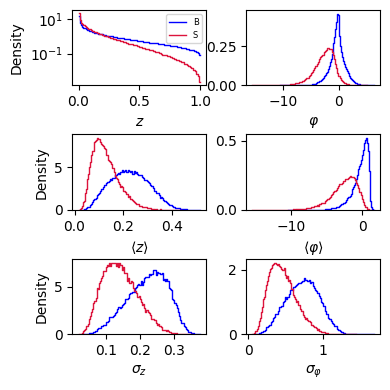

In [3]:
from math import pi
import matplotlib.pyplot as plt
import seaborn as sns


# toy_qcd = np.load('synthetic_data/toy_bkg_data_2M.npy')
# toy_tops = np.load('synthetic_data/toy_sig_data_2M.npy')

qcd_x = toy_qcd[:, :, 0].flatten()
qcd_y = toy_qcd[:, :, 1].flatten()
tops_x = toy_tops[:, :, 0].flatten()
tops_y = toy_tops[:, :, 1].flatten()

qcd_x_mean = toy_qcd[:, :, 0].mean(axis=1)
qcd_y_mean = toy_qcd[:, :, 1].mean(axis=1)
tops_x_mean = toy_tops[:, :, 0].mean(axis=1)
tops_y_mean = toy_tops[:, :, 1].mean(axis=1)

qcd_x_std = toy_qcd[:, :, 0].std(axis=1)
qcd_y_std = toy_qcd[:, :, 1].std(axis=1)
tops_x_std = toy_tops[:, :, 0].std(axis=1)
tops_y_std = toy_tops[:, :, 1].std(axis=1)


# --- Create subplots ---
fig, ax = plt.subplots(3, 2, figsize=(4, 4))

# bins=np.linspace(0,1,40)
bins=100
# --- Plot the histograms ---

# Top row: x and y distributions of z and phi.
sns.histplot(qcd_x, bins=bins, fill=False, color='blue', lw=1, label='B', element='step', stat='density', ax=ax[0, 0])
sns.histplot(tops_x, bins=bins, fill=False, color='crimson', lw=1, label='S', element='step', stat='density', ax=ax[0, 0])

ax[0,0].set_ylabel('Density')
ax[0,0].set_xlabel(r'$z$')
ax[0,0].set_yscale('log')
ax[0,0].legend(loc='upper right', fontsize=6)


sns.histplot(qcd_y, bins=bins, fill=False, color='blue', lw=1, label='B', element='step', stat='density', ax=ax[0, 1])
sns.histplot(tops_y, bins=bins, fill=False, color='crimson', lw=1, label='S', element='step', stat='density', ax=ax[0, 1])
ax[0,1].set_ylabel('')
ax[0,1].set_xlabel(r'$\varphi$')

bins=100

# Middle row: mean distributions
sns.histplot(qcd_x_mean, bins=bins, fill=False, color='blue', lw=1, label='B', element='step', stat='density', ax=ax[1, 0])
sns.histplot(tops_x_mean, bins=bins, fill=False, color='crimson', lw=1, label='S', element='step', stat='density', ax=ax[1, 0])
ax[1,0].set_ylabel('Density')
ax[1,0].set_xlabel(r'$\langle z\rangle$')

sns.histplot(qcd_y_mean, bins=bins, fill=False, color='blue', lw=1, label='B', element='step', stat='density', ax=ax[1, 1])
sns.histplot(tops_y_mean, bins=bins, fill=False, color='crimson', lw=1, label='S', element='step', stat='density', ax=ax[1, 1])
ax[1,1].set_ylabel('')
ax[1,1].set_xlabel(r'$\langle\varphi\rangle$')

# Bottom row: standard deviation distributions
sns.histplot(qcd_x_std, bins=bins, fill=False, color='blue', lw=1, label='B', element='step', stat='density', ax=ax[2, 0])
sns.histplot(tops_x_std, bins=bins, fill=False, color='crimson', lw=1, label='S', element='step', stat='density', ax=ax[2, 0])
ax[2,0].set_ylabel('Density')
ax[2,0].set_xlabel(r'$\sigma_z$')

sns.histplot(qcd_y_std, bins=bins, fill=False, color='blue', lw=1, label='B', element='step', stat='density', ax=ax[2, 1])
sns.histplot(tops_y_std, bins=bins, fill=False, color='crimson', lw=1, label='S', element='step', stat='density', ax=ax[2, 1])
ax[2,1].set_ylabel('')
ax[2,1].set_xlabel(r'$\sigma_\varphi$')

custom_ticks = {
    0: [0, 0.2, 0.4, 0.6, 0.8, 1],
    1: [-8, -4, 0, 4, 8],
    2: [0, 0.1, 0.2, 0.3, 0.4, 0.5] ,
    3: [-8, -4, 0, 4, 8],
    4: [0, 0.1, 0.2, 0.3, 0.4],
    5: [0, 1, 2, 3, 4, 5, 6]
}

plt.tight_layout()
fig.subplots_adjust(hspace=0.65, wspace=0.3) 
plt.savefig('synthetic_jets.png', dpi=300, bbox_inches='tight')
plt.show()


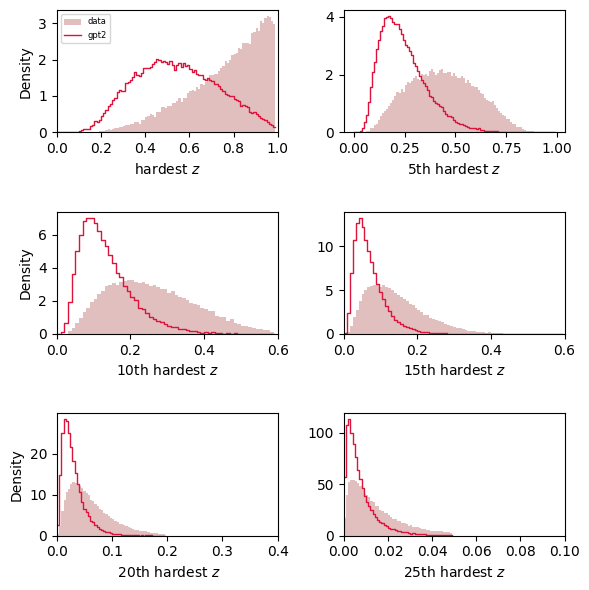

In [24]:
from utils import ordered_z_plots

def canonical_order(samples):
    idx = np.argsort(-samples[:, :, 0], axis=1)
    return np.take_along_axis(samples, idx[:, :, None], axis=1)


toy_qcd_ord = canonical_order(toy_qcd)
toy_tops_ord = canonical_order(toy_tops)

ordered_z_plots(toy_qcd_ord, toy_tops_ord)

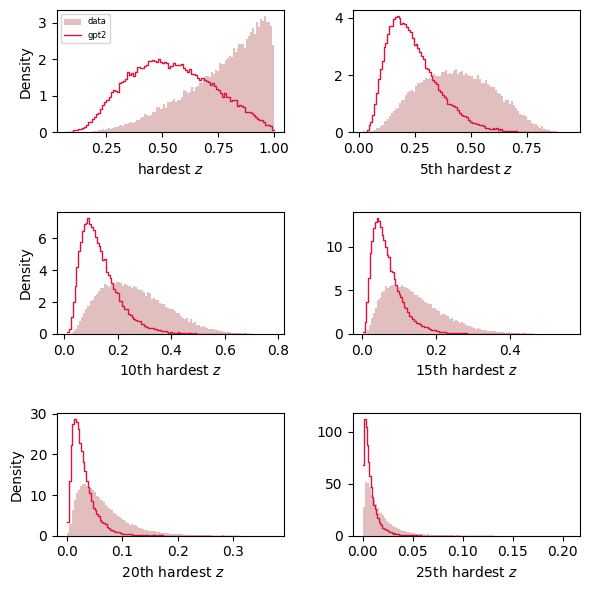

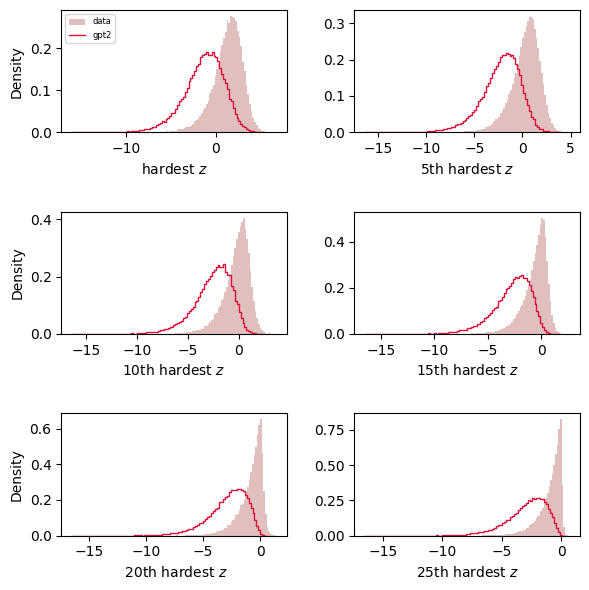

In [25]:

def ordered_z_plots(toy_qcd, gen_jets, save_file='ordered_z_plots.png', feat=0):

    fig, ax = plt.subplots(3, 2, figsize=(6, 6))

    bins=100

    # --- Plot hardest ---

    sns.histplot(toy_qcd[:,0,:][...,feat], bins=bins, alpha=0.25, color='darkred', lw=0, label='data', element='step', stat='density', ax=ax[0, 0])
    sns.histplot(gen_jets[:,0,:][...,feat], bins=bins,  fill=False, color='crimson', lw=1, label='gpt2', element='step', stat='density', ax=ax[0, 0])

    ax[0,0].set_ylabel('Density')
    ax[0,0].set_xlabel(r'hardest $z$')
    ax[0,0].legend(loc='upper left', fontsize=6)
    # ax[0,0].set_xlim(0, 1)


    sns.histplot(toy_qcd[:,5,:][...,feat], bins=bins,   alpha=0.25, color='darkred', lw=0, label='B', element='step', stat='density', ax=ax[0, 1])
    sns.histplot(gen_jets[:,5,:][...,feat], bins=bins,  fill=False, color='crimson', lw=1, label='gpt2', element='step', stat='density', ax=ax[0, 1])
    ax[0,1].set_ylabel('')
    ax[0,1].set_xlabel(r'5th hardest $z$')


    # bins=np.arange(0, 0.6, 0.01)

    sns.histplot(toy_qcd[:,10,:][...,feat], bins=bins,  alpha=0.25, color='darkred', lw=0, label='B', element='step', stat='density', ax=ax[1, 0])
    sns.histplot(gen_jets[:,10,:][...,feat], bins=bins,  fill=False, color='crimson', lw=1, label='S', element='step', stat='density', ax=ax[1, 0])

    ax[1,0].set_ylabel('Density')
    ax[1,0].set_xlabel(r'10th hardest $z$')
    # ax[1,0].legend(loc='upper right', fontsize=6)
    # ax[1,0].set_xlim(0, 0.6)

    # bins=np.arange(0, 0.6, 0.008)

    sns.histplot(toy_qcd[:,15,:][...,feat], bins=bins,  alpha=0.25, color='darkred', lw=0, label='B', element='step', stat='density', ax=ax[1, 1])
    sns.histplot(gen_jets[:,15,:][...,feat], bins=bins, fill=False, color='crimson', lw=1, label='S', element='step', stat='density', ax=ax[1, 1])
    ax[1,1].set_ylabel('')
    ax[1,1].set_xlabel(r'15th hardest $z$')
    # ax[1,1].legend(loc='upper right', fontsize=6)
    # ax[1,1].set_xlim(0, 0.6)


    # Middle row: intermediate distributions

    # bins=np.arange(0, 0.2, 0.004)

    sns.histplot(toy_qcd[:,20,:][...,feat], bins=bins,  alpha=0.25, color='darkred', lw=0, label='B', element='step', stat='density', ax=ax[2, 0])
    sns.histplot(gen_jets[:,20,:][...,feat], bins=bins, fill=False,  color='crimson', lw=1, label='S', element='step', stat='density', ax=ax[2, 0])

    ax[2,0].set_ylabel('Density')
    ax[2,0].set_xlabel(r' 20th hardest $z$')
    # ax[2,0].legend(loc='upper right', fontsize=6)
    # ax[2,0].set_xlim(0, 0.4)


    # bins=np.arange(0, 0.05, 0.001)

    sns.histplot(toy_qcd[:,25,:][...,feat], bins=bins,  alpha=0.25, color='darkred', lw=0, label='B', element='step', stat='density', ax=ax[2, 1])
    sns.histplot(gen_jets[:,25,:][...,feat], bins=bins, fill=False,  color='crimson', lw=1, label='S', element='step', stat='density', ax=ax[2, 1])
    ax[2,1].set_ylabel('')
    ax[2,1].set_xlabel(r'25th hardest $z$')
    # ax[2,1].legend(loc='upper right', fontsize=6)
    # ax[2,1].set_xlim(0, 0.1)

    plt.tight_layout()
    fig.subplots_adjust(hspace=0.65, wspace=0.3) 
    plt.savefig(save_file, dpi=300, bbox_inches='tight')

    plt.show()
    
ordered_z_plots(toy_qcd_ord, toy_tops_ord, feat=0)
ordered_z_plots(toy_qcd_ord, toy_tops_ord, feat=1)

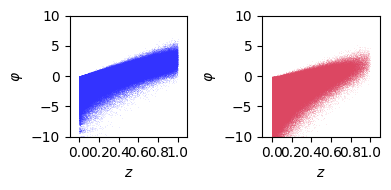

In [4]:
# plot scatterplot of first vs second feature
fig, ax = plt.subplots(1, 2, figsize=(4, 2))
sns.scatterplot(x=qcd_x, y=qcd_y, color='blue', alpha=0.1, s=0.5, ax=ax[0])
ax[0].set_xlabel(r'$z$')
ax[0].set_ylabel(r'$\varphi$')
ax[0].set_xlim(-0.1, 1.1)
ax[0].set_ylim(-10, 10)
ax[0].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax[0].set_yticks([-10, -5, 0, 5, 10])

sns.scatterplot(x=tops_x, y=tops_y, color='crimson', alpha=0.1, s=0.5, ax=ax[1])
ax[1].set_xlabel(r'$z$')
ax[1].set_ylabel(r'$\varphi$')
ax[1].set_xlim(-0.1, 1.1)
ax[1].set_ylim(-10, 10)
ax[1].set_yscale('linear')
ax[1].set_xscale('linear')
ax[1].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax[1].set_yticks([-10, -5, 0, 5, 10])

plt.tight_layout()
plt.show()



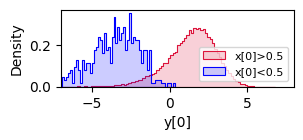

In [30]:
hardest = toy_qcd_ord[:,0]
hardest[hardest[...,0] > 0.5][...,1]

plt.figure(figsize=(3,1.))
sns.histplot(hardest[hardest[...,0] > 0.3][...,1], bins=100, color='crimson', alpha=0.2, lw=0.8, label='x[0]>0.5', element='step', stat='density')
sns.histplot(hardest[hardest[...,0] <= 0.3][...,1], bins=100, color='blue', alpha=0.2, lw=0.8, label='x[0]<0.5', element='step', stat='density')
plt.xlabel(r'y[0]')
plt.xlim(-7, 8)
plt.ylabel('Density')
# plt.yscale('log')
plt.legend(loc='lower right', fontsize=8)
# plt.savefig('toy_LLR.png', dpi=300, bbox_inches='tight')
plt.show()

In [6]:
LLR_qcd

array([  0.        ,   0.        ,   0.        , ...,   0.        ,
         0.        , -18.36221662])

/tmp/ipykernel_2304916/2099719331.py:96: RuntimeWarning: overflow encountered in exp
  return np.exp(I + J)
/tmp/ipykernel_2304916/2099719331.py:99: RuntimeWarning: divide by zero encountered in log
  logp += np.log(val)
/tmp/ipykernel_2304916/4231955321.py:6: RuntimeWarning: invalid value encountered in subtract
  LLR_qcd = logp_tops_on_qcd - logp_qcd_on_qcd
/tmp/ipykernel_2304916/4231955321.py:7: RuntimeWarning: invalid value encountered in subtract
  LLR_tops = logp_qcd_on_tops - logp_tops_on_tops
/home/df630/.conda/envs/markov_bridges/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/df630/SyntheticJets/utils.py:17: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr, 1 / fpr, label=f"{label} (AUC = {roc_auc:.2f})")


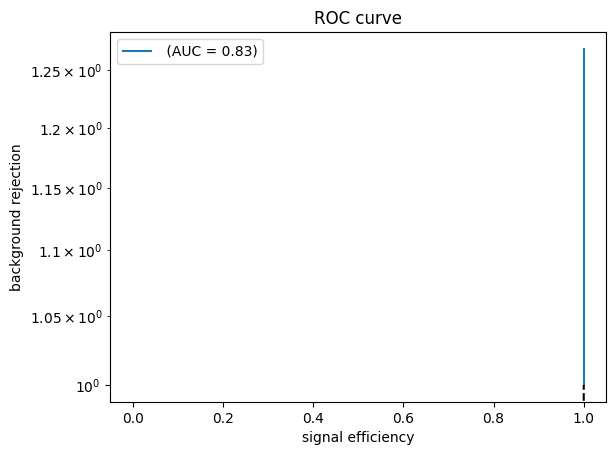

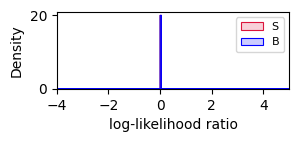

In [5]:
logp_qcd_on_qcd = qcd.log_probs(toy_qcd)
logp_tops_on_tops = tops.log_probs(toy_tops)
logp_qcd_on_tops = qcd.log_probs(toy_tops)
logp_tops_on_qcd = tops.log_probs(toy_qcd)

LLR_qcd = logp_tops_on_qcd - logp_qcd_on_qcd
LLR_tops = logp_qcd_on_tops - logp_tops_on_tops

from utils import ROC
LLR_tops_ = np.nan_to_num(LLR_tops, 0)
LLR_qcd_ = np.nan_to_num(LLR_qcd, 0)

ROC(LLR_qcd, LLR_tops, label='')



plt.figure(figsize=(3,1.))
sns.histplot(LLR_qcd, bins=np.arange(-4,10,0.05), color='crimson', alpha=0.2, lw=0.8, label='S', element='step', stat='density')
sns.histplot(LLR_tops, bins=np.arange(-4,10,0.05), color='blue', alpha=0.2, lw=0.8, label='B', element='step', stat='density')
plt.xlabel(r'log-likelihood ratio')
plt.xlim(-4, 5)
plt.ylabel('Density')
# plt.yscale('log')
plt.legend(loc='upper right', fontsize=8)
# plt.savefig('toy_LLR.png', dpi=300, bbox_inches='tight')
plt.show()

# MAF data analysis

In [2]:
toy_qcd = np.load('synthetic_data/toy_bkg_data_2M.npy')[:50000]
toy_tops = np.load('synthetic_data/toy_sig_data_2M.npy')[:50000]
fm_qcd = np.load('synthetic_data/FM_gen_bkg_data_2M.npy')[:50000]
fm_tops = np.load('synthetic_data/FM_gen_sig_data_2M.npy')[:50000]
maf_qcd = np.load('synthetic_data/MAF_background_samples_30.npy')
maf_tops = np.load('synthetic_data/MAF_signal_samples_30.npy')

# Replace NaNs with zeros
maf_qcd = np.nan_to_num(maf_qcd, nan=0)
maf_tops = np.nan_to_num(maf_tops, nan=0)

# Clip the first coordinate ([..., 0]) between 0 and 1
maf_qcd[..., 0] = np.clip(maf_qcd[..., 0], 0, 1)
maf_tops[..., 0] = np.clip(maf_tops[..., 0], 0, 1)

# Clip the second coordinate ([..., 1]) between -8 and 8
maf_qcd[..., 1] = np.clip(maf_qcd[..., 1], -8, 8)
maf_tops[..., 1] = np.clip(maf_tops[..., 1], -8, 8)



In [3]:
toy_qcd_ord = canonical_order(toy_qcd)
toy_tops_ord = canonical_order(toy_tops)
fm_qcd_ord = canonical_order(fm_qcd)
fm_tops_ord = canonical_order(fm_tops)
maf_qcd_ord = canonical_order(maf_qcd)
maf_tops_ord = canonical_order(maf_tops)

toy_qcd_shuf = shuffle_samples(toy_qcd)
toy_tops_shuf = shuffle_samples(toy_tops)
fm_qcd_shuf = shuffle_samples(fm_qcd)
fm_tops_shuf = shuffle_samples(fm_tops)
maf_qcd_shuf = shuffle_samples(maf_qcd)
maf_tops_shuf = shuffle_samples(maf_tops)

toy_qcd_ord_shuff = shuffle_samples(canonical_order(toy_qcd))
toy_tops_ord_shuff = shuffle_samples(canonical_order(toy_tops))
fm_qcd_ord_shuff = shuffle_samples(canonical_order(fm_qcd))
fm_tops_ord_shuff = shuffle_samples(canonical_order(fm_tops))
maf_qcd_ord_shuff = shuffle_samples(canonical_order(maf_qcd))
maf_tops_ord_shuff = shuffle_samples(canonical_order(maf_tops))


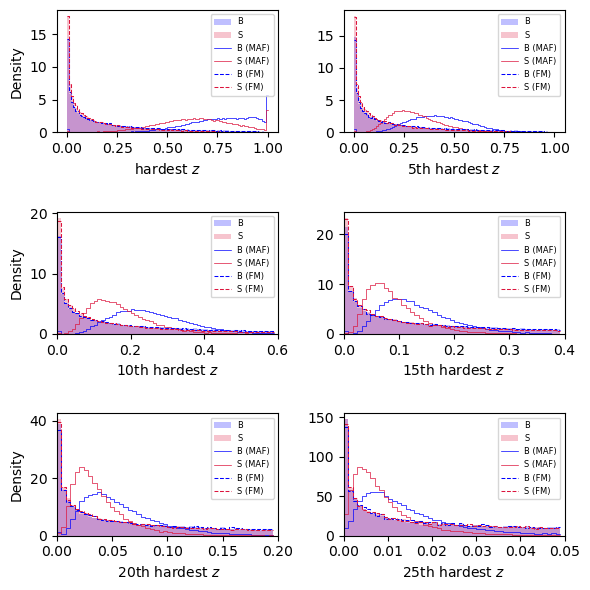

In [6]:
ordered_z_plots(toy_qcd, toy_tops, maf_qcd, maf_tops, fm_qcd, fm_tops,)

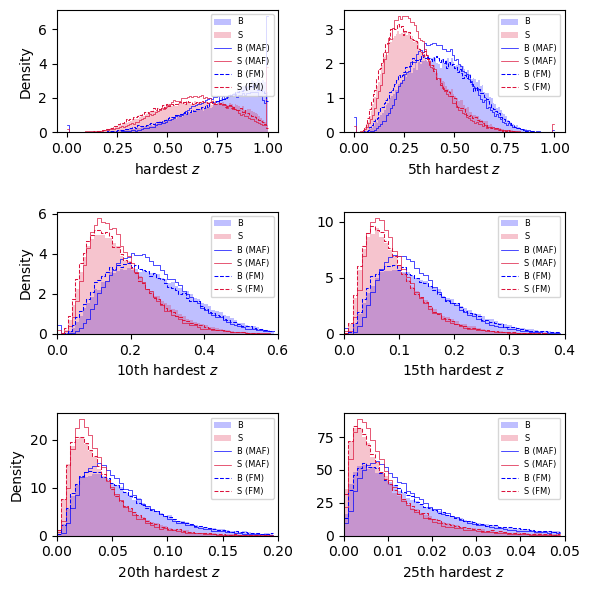

In [7]:
ordered_z_plots(toy_qcd_ord, toy_tops_ord, maf_qcd_ord, maf_tops_ord, fm_qcd_ord, fm_tops_ord,)

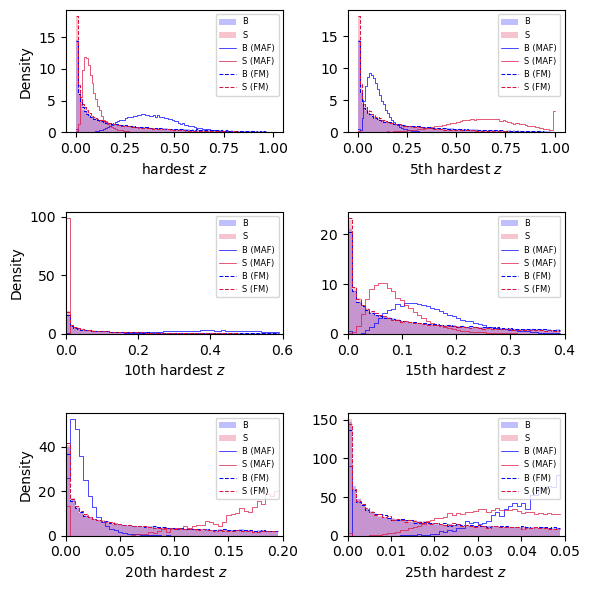

In [8]:
ordered_z_plots(toy_qcd_shuf, toy_tops_shuf, maf_qcd_shuf, maf_tops_shuf, fm_qcd_shuf, fm_tops_shuf,)

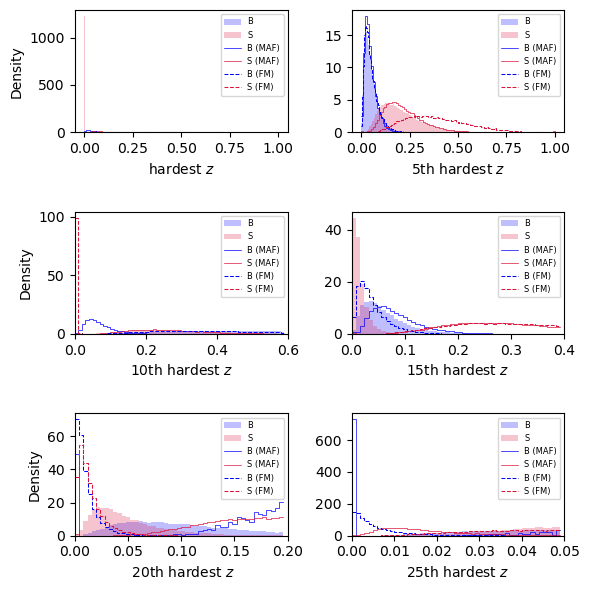

In [9]:
ordered_z_plots(toy_qcd_ord_shuff, toy_tops_ord_shuff, maf_qcd_ord_shuff, maf_tops_ord_shuff, fm_qcd_ord_shuff, fm_tops_ord_shuff,)

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


def ordered_z_plots(toy_qcd, toy_tops, maf_qcd, maf_tops, fm_qcd, fm_tops):

    fig, ax = plt.subplots(3, 2, figsize=(6, 6))

    bins=100

    # --- Plot hardest ---

    sns.histplot(toy_qcd[:,0,:][...,0], bins=bins,  alpha=0.25, color='blue', lw=0, label='B', element='step', stat='density', ax=ax[0, 0])
    sns.histplot(toy_tops[:,0,:][...,0], bins=bins,  alpha=0.25, color='crimson', lw=0, label='S', element='step', stat='density', ax=ax[0, 0])
    sns.histplot(maf_qcd[:,0,:][...,0], bins=bins, fill=False, color='blue', lw=0.5, label='B (MAF)', element='step', stat='density', ax=ax[0, 0])
    sns.histplot(maf_tops[:,0,:][...,0], bins=bins, fill=False, color='crimson', lw=0.5, label='S (MAF)', element='step', stat='density', ax=ax[0, 0])
    sns.histplot(fm_qcd[:,0,:][...,0], bins=bins, fill=False, color='blue', ls='--', lw=0.75, label='B (FM)', element='step', stat='density', ax=ax[0, 0])
    sns.histplot(fm_tops[:,0,:][...,0], bins=bins, fill=False, color='crimson', ls='--', lw=0.75, label='S (FM)', element='step', stat='density', ax=ax[0, 0])

    ax[0,0].set_ylabel('Density')
    ax[0,0].set_xlabel(r'hardest $z$')
    ax[0,0].legend(loc='upper right', fontsize=6)

    sns.histplot(toy_qcd[:,5,:][...,0], bins=bins,  alpha=0.25, color='blue', lw=0, label='B', element='step', stat='density', ax=ax[0, 1])
    sns.histplot(toy_tops[:,5,:][...,0], bins=bins,  alpha=0.25, color='crimson', lw=0, label='S', element='step', stat='density', ax=ax[0, 1])
    sns.histplot(maf_qcd[:,5,:][...,0], bins=bins, fill=False, color='blue', lw=0.5, label='B (MAF)', element='step', stat='density', ax=ax[0, 1])
    sns.histplot(maf_tops[:,5,:][...,0], bins=bins, fill=False, color='crimson', lw=0.5, label='S (MAF)', element='step', stat='density', ax=ax[0, 1])
    sns.histplot(fm_qcd[:,5,:][...,0], bins=bins, fill=False, color='blue', ls='--', lw=0.75, label='B (FM)', element='step', stat='density', ax=ax[0, 1])
    sns.histplot(fm_tops[:,5,:][...,0], bins=bins, fill=False, color='crimson', ls='--', lw=0.75, label='S (FM)', element='step', stat='density', ax=ax[0, 1])
    ax[0,1].set_ylabel('')
    ax[0,1].set_xlabel(r'5th hardest $z$')
    ax[0,1].legend(loc='upper right', fontsize=6)

    # Middle row: intermediate distributions

    bins=np.arange(0, 0.6, 0.01)

    sns.histplot(toy_qcd[:,10,:][...,0], bins=bins,  alpha=0.25, color='blue', lw=0, label='B', element='step', stat='density', ax=ax[1, 0])
    sns.histplot(toy_tops[:,10,:][...,0], bins=bins,  alpha=0.25, color='crimson', lw=0, label='S', element='step', stat='density', ax=ax[1, 0])
    sns.histplot(maf_qcd[:,10,:][...,0], bins=bins, fill=False, color='blue', lw=0.5, label='B (MAF)', element='step', stat='density', ax=ax[1, 0])
    sns.histplot(maf_tops[:,10,:][...,0], bins=bins, fill=False, color='crimson', lw=0.5, label='S (MAF)', element='step', stat='density', ax=ax[1, 0])
    sns.histplot(fm_qcd[:,10,:][...,0], bins=bins, fill=False, color='blue', ls='--', lw=0.75, label='B (FM)', element='step', stat='density', ax=ax[1, 0])
    sns.histplot(fm_tops[:,10,:][...,0], bins=bins, fill=False, color='crimson', ls='--', lw=0.75, label='S (FM)', element='step', stat='density', ax=ax[1, 0])

    ax[1,0].set_ylabel('Density')
    ax[1,0].set_xlabel(r'10th hardest $z$')
    ax[1,0].legend(loc='upper right', fontsize=6)
    ax[1,0].set_xlim(0, 0.6)

    bins=np.arange(0, 0.4, 0.008)

    sns.histplot(toy_qcd[:,15,:][...,0], bins=bins,  alpha=0.25, color='blue', lw=0, label='B', element='step', stat='density', ax=ax[1, 1])
    sns.histplot(toy_tops[:,15,:][...,0], bins=bins,  alpha=0.25, color='crimson', lw=0, label='S', element='step', stat='density', ax=ax[1, 1])
    sns.histplot(maf_qcd[:,15,:][...,0], bins=bins, fill=False, color='blue', lw=0.5, label='B (MAF)', element='step', stat='density', ax=ax[1, 1])
    sns.histplot(maf_tops[:,15,:][...,0], bins=bins, fill=False, color='crimson', lw=0.5, label='S (MAF)', element='step', stat='density', ax=ax[1, 1])
    sns.histplot(fm_qcd[:,15,:][...,0], bins=bins, fill=False, color='blue', ls='--', lw=0.75, label='B (FM)', element='step', stat='density', ax=ax[1, 1])
    sns.histplot(fm_tops[:,15,:][...,0], bins=bins, fill=False, color='crimson', ls='--', lw=0.75, label='S (FM)', element='step', stat='density', ax=ax[1, 1])
    ax[1,1].set_ylabel('')
    ax[1,1].set_xlabel(r'15th hardest $z$')
    ax[1,1].legend(loc='upper right', fontsize=6)
    ax[1,1].set_xlim(0, 0.4)


    # Middle row: intermediate distributions

    bins=np.arange(0, 0.2, 0.004)

    sns.histplot(toy_qcd[:,20,:][...,0], bins=bins,  alpha=0.25, color='blue', lw=0, label='B', element='step', stat='density', ax=ax[2, 0])
    sns.histplot(toy_tops[:,20,:][...,0], bins=bins,  alpha=0.25, color='crimson', lw=0, label='S', element='step', stat='density', ax=ax[2, 0])
    sns.histplot(maf_qcd[:,20,:][...,0], bins=bins, fill=False, color='blue', lw=0.5, label='B (MAF)', element='step', stat='density', ax=ax[2, 0])
    sns.histplot(maf_tops[:,20,:][...,0], bins=bins, fill=False, color='crimson', lw=0.5, label='S (MAF)', element='step', stat='density', ax=ax[2, 0])
    sns.histplot(fm_qcd[:,20,:][...,0], bins=bins, fill=False, color='blue', ls='--', lw=0.75, label='B (FM)', element='step', stat='density', ax=ax[2, 0])
    sns.histplot(fm_tops[:,20,:][...,0], bins=bins, fill=False, color='crimson', ls='--', lw=0.75, label='S (FM)', element='step', stat='density', ax=ax[2, 0])

    ax[2,0].set_ylabel('Density')
    ax[2,0].set_xlabel(r' 20th hardest $z$')
    ax[2,0].legend(loc='upper right', fontsize=6)
    ax[2,0].set_xlim(0, 0.2)


    bins=np.arange(0, 0.05, 0.001)

    sns.histplot(toy_qcd[:,25,:][...,0], bins=bins,  alpha=0.25, color='blue', lw=0, label='B', element='step', stat='density', ax=ax[2, 1])
    sns.histplot(toy_tops[:,25,:][...,0], bins=bins,  alpha=0.25, color='crimson', lw=0, label='S', element='step', stat='density', ax=ax[2, 1])
    sns.histplot(maf_qcd[:,25,:][...,0], bins=bins, fill=False, color='blue', lw=0.5, label='B (MAF)', element='step', stat='density', ax=ax[2, 1])
    sns.histplot(maf_tops[:,25,:][...,0], bins=bins, fill=False, color='crimson', lw=0.5, label='S (MAF)', element='step', stat='density', ax=ax[2, 1])
    sns.histplot(fm_qcd[:,25,:][...,0], bins=bins, fill=False, color='blue', ls='--', lw=0.75, label='B (FM)', element='step', stat='density', ax=ax[2, 1])
    sns.histplot(fm_tops[:,25,:][...,0], bins=bins, fill=False, color='crimson', ls='--', lw=0.75, label='S (FM)', element='step', stat='density', ax=ax[2, 1])
    ax[2,1].set_ylabel('')
    ax[2,1].set_xlabel(r'25th hardest $z$')
    ax[2,1].legend(loc='upper right', fontsize=6)
    ax[2,1].set_xlim(0, 0.05)

    plt.tight_layout()
    fig.subplots_adjust(hspace=0.65, wspace=0.3) 
    plt.show()


In [ ]:
from math import pi
import matplotlib.pyplot as plt
import seaborn as sns

qcd_maf_x = maf_qcd[:, :, 0].flatten()
qcd_maf_y = maf_qcd[:, :, 1].flatten()
tops_maf_x = maf_tops[:, :, 0].flatten()
tops_maf_y = maf_tops[:, :, 1].flatten()

qcd_fm_x = fm_qcd[:, :, 0].flatten()    
qcd_fm_y = fm_qcd[:, :, 1].flatten()
tops_fm_x = fm_tops[:, :, 0].flatten()
tops_fm_y = fm_tops[:, :, 1].flatten()

qcd_maf_x_mean = maf_qcd[:, :, 0].mean(axis=1)
qcd_maf_y_mean = maf_qcd[:, :, 1].mean(axis=1)
tops_maf_x_mean = maf_tops[:, :, 0].mean(axis=1)
tops_maf_y_mean = maf_tops[:, :, 1].mean(axis=1)

qcd_fm_x_mean = fm_qcd[:, :, 0].mean(axis=1)
qcd_fm_y_mean = fm_qcd[:, :, 1].mean(axis=1)
tops_fm_x_mean = fm_tops[:, :, 0].mean(axis=1)
tops_fm_y_mean = fm_tops[:, :, 1].mean(axis=1)

qcd_maf_x_std = maf_qcd[:, :, 0].std(axis=1)
qcd_maf_y_std = maf_qcd[:, :, 1].std(axis=1)
tops_maf_x_std = maf_tops[:, :, 0].std(axis=1)
tops_maf_y_std = maf_tops[:, :, 1].std(axis=1)

qcd_fm_x_std = fm_qcd[:, :, 0].std(axis=1)
qcd_fm_y_std = fm_qcd[:, :, 1].std(axis=1)
tops_fm_x_std = fm_tops[:, :, 0].std(axis=1)
tops_fm_y_std = fm_tops[:, :, 1].std(axis=1)

# --- Create subplots ---
fig, ax = plt.subplots(3, 2, figsize=(6, 6))

bins=100
# --- Plot the histograms ---

# Top row: x and y distributions of z and phi.
sns.histplot(qcd_x, bins=bins, alpha=0.25, color='blue', lw=0, label='B data', element='step', stat='density', ax=ax[0, 0])
sns.histplot(tops_x, bins=bins, alpha=0.25, color='crimson', lw=0, label='S data', element='step', stat='density', ax=ax[0, 0])
sns.histplot(qcd_maf_x, bins=bins, fill=False, color='blue', ls='-', lw=0.5, label='B MAF', element='step', stat='density', ax=ax[0, 0])
sns.histplot(tops_maf_x, bins=bins, fill=False, color='crimson', ls='-', lw=0.5, label='S MAF', element='step', stat='density', ax=ax[0, 0])
sns.histplot(qcd_fm_x, bins=bins, fill=False, color='blue', ls='--', lw=0.75, label='B FM', element='step', stat='density', ax=ax[0, 0])
sns.histplot(tops_fm_x, bins=bins, fill=False, color='crimson', ls='--', lw=0.75, label='S FM', element='step', stat='density', ax=ax[0, 0])

ax[0,0].set_ylabel('Density')
ax[0,0].set_xlabel(r'$z$')
ax[0,0].set_yscale('log')
ax[0,0].set_ylim(7e-3, 1e2)
ax[0,0].legend(loc='upper right', fontsize=5)


sns.histplot(qcd_maf_y, bins=bins, fill=False, color='blue',  ls='-', lw=0.5, label='B', element='step', stat='density', ax=ax[0, 1])
sns.histplot(tops_maf_y, bins=bins, fill=False, color='crimson',  ls='-', lw=0.5, label='S', element='step', stat='density', ax=ax[0, 1])
sns.histplot(qcd_y, bins=bins, alpha=0.25, color='blue', lw=0, label='B (MAF)', element='step', stat='density', ax=ax[0, 1])
sns.histplot(tops_y, bins=bins, alpha=0.25, color='crimson', lw=0, label='S (MAF)', element='step', stat='density', ax=ax[0, 1])
sns.histplot(qcd_fm_y, bins=bins, fill=False, color='blue', ls='--', lw=0.75, label='B (FM)', element='step', stat='density', ax=ax[0, 1])
sns.histplot(tops_fm_y, bins=bins, fill=False, color='crimson', ls='--', lw=0.75, label='S (FM)', element='step', stat='density', ax=ax[0, 1])

ax[0,1].set_ylabel('')
ax[0,1].set_xlabel(r'$\varphi$')
ax[0,1].legend(loc='upper right', fontsize=6)


bins=np.arange(0,0.5,0.01)

# Middle row: mean distributions
sns.histplot(qcd_x_mean, bins=bins, alpha=0.25, color='blue', lw=0, label='B', element='step', stat='density', ax=ax[1, 0])
sns.histplot(tops_x_mean, bins=bins, alpha=0.25, color='crimson', lw=0, label='S', element='step', stat='density', ax=ax[1, 0])
sns.histplot(qcd_maf_x_mean, bins=bins, fill=False, color='blue',  ls='-', lw=0.5, label='B (MAF)', element='step', stat='density', ax=ax[1, 0])
sns.histplot(tops_maf_x_mean, bins=bins, fill=False, color='crimson',  ls='-', lw=0.5, label='S (MAF)', element='step', stat='density', ax=ax[1, 0])
sns.histplot(qcd_fm_x_mean, bins=bins, fill=False, color='blue', ls='--', lw=0.75, label='B (FM)', element='step', stat='density', ax=ax[1, 0])
sns.histplot(tops_fm_x_mean, bins=bins, fill=False, color='crimson', ls='--', lw=0.75, label='S (FM)', element='step', stat='density', ax=ax[1, 0])

ax[1,0].set_ylabel('Density')
ax[1,0].set_xlabel(r'$\langle z\rangle$')
ax[1,0].legend(loc='upper right', fontsize=6)

bins=100

sns.histplot(qcd_y_mean, bins=bins, alpha=0.25, color='blue', lw=0, label='B', element='step', stat='density', ax=ax[1, 1])
sns.histplot(tops_y_mean, bins=bins, alpha=0.25, color='crimson', lw=0, label='S', element='step', stat='density', ax=ax[1, 1])
sns.histplot(qcd_maf_y_mean, bins=bins, fill=False, color='blue',  ls='-', lw=0.5, label='B (MAF)', element='step', stat='density', ax=ax[1, 1])
sns.histplot(tops_maf_y_mean, bins=bins, fill=False, color='crimson',  ls='-', lw=0.5, label='S (MAF)', element='step', stat='density', ax=ax[1, 1])
sns.histplot(qcd_fm_y_mean, bins=bins, fill=False, color='blue', ls='--', lw=0.75, label='B (FM)', element='step', stat='density', ax=ax[1, 1])
sns.histplot(tops_fm_y_mean, bins=bins, fill=False, color='crimson', ls='--', lw=0.75, label='S (FM)', element='step', stat='density', ax=ax[1, 1])


ax[1,1].set_ylabel('')
ax[1,1].set_xlabel(r'$\langle\varphi\rangle$')
ax[1,1].legend(loc='upper right', fontsize=6)

bins=np.arange(0,0.5,0.01)

sns.histplot(qcd_x_std, bins=bins, alpha=0.25, color='blue', lw=0, label='B', element='step', stat='density', ax=ax[2, 0])
sns.histplot(tops_x_std, bins=bins, alpha=0.25, color='crimson', lw=0, label='S', element='step', stat='density', ax=ax[2, 0])
sns.histplot(qcd_maf_x_std, bins=bins, fill=False, color='blue',  ls='-', lw=0.5, label='B (MAF)', element='step', stat='density', ax=ax[2, 0])
sns.histplot(tops_maf_x_std, bins=bins, fill=False, color='crimson',  ls='-', lw=0.5, label='S (MAF)', element='step', stat='density', ax=ax[2, 0])
sns.histplot(qcd_fm_x_std, bins=bins, fill=False, color='blue', ls='--', lw=0.75, label='B (FM)', element='step', stat='density', ax=ax[2, 0])
sns.histplot(tops_fm_x_std, bins=bins, fill=False, color='crimson', ls='--', lw=0.75, label='S (FM)', element='step', stat='density', ax=ax[2, 0])

ax[2,0].set_ylabel('Density')
ax[2,0].set_xlabel(r'$\sigma_z$')
ax[2,0].legend(loc='upper right', fontsize=6)

bins=np.arange(0.5,1.5,0.005)

sns.histplot(qcd_y_std, bins=bins, alpha=0.25, color='blue', lw=0, label='B', element='step', stat='density', ax=ax[2, 1])
sns.histplot(tops_y_std, bins=bins, alpha=0.25, color='crimson', lw=0, label='S', element='step', stat='density', ax=ax[2, 1])
sns.histplot(qcd_maf_y_std, bins=bins, fill=False, color='blue',  ls='-', lw=0.5, label='B (MAF)', element='step', stat='density', ax=ax[2, 1])
sns.histplot(tops_maf_y_std, bins=bins, fill=False, color='crimson',  ls='-', lw=0.5, label='S (MAF)', element='step', stat='density', ax=ax[2, 1])
sns.histplot(qcd_fm_y_std, bins=bins, fill=False, color='blue', ls='--', lw=0.75, label='B (FM)', element='step', stat='density', ax=ax[2, 1])
sns.histplot(tops_fm_y_std, bins=bins, fill=False, color='crimson', ls='--', lw=0.75, label='S (FM)', element='step', stat='density', ax=ax[2, 1])

ax[2,1].set_ylabel('')
ax[2,1].set_xlabel(r'$\sigma_\varphi$')
ax[2,1].legend(loc='upper right', fontsize=6)

custom_ticks = {
    0: [0, 0.2, 0.4, 0.6, 0.8, 1],
    1: [-8, -4, 0, 4, 8],
    2: [0, 0.1, 0.2, 0.3, 0.4, 0.5] ,
    3: [-8, -4, 0, 4, 8],
    4: [0, 0.1, 0.2, 0.3, 0.4],
    5: [0.5, 0.75, 1, 1.25, 1.5]
}

# For each axis, set custom ticks based on its column:
for i in range(3):  # rows
    for j in range(2):  # columns
        if j == 0:
            if i == 0:
                ax[i, j].set_xticks(custom_ticks[0])
            elif i == 1:
                ax[i, j].set_xticks(custom_ticks[2])
            elif i == 2:
                ax[i, j].set_xticks(custom_ticks[4])
        elif j == 1:
            if i == 0:
                ax[i, j].set_xticks(custom_ticks[1])
            elif i == 1:
                ax[i, j].set_xticks(custom_ticks[3])
            elif i == 2:
                ax[i, j].set_xticks(custom_ticks[5])

        ax[i, j].tick_params(axis='x', labelsize=8)
        ax[i, j].tick_params(axis='y', labelsize=8)

ax[1,0].set_xlim(0, 0.5)
ax[0,1].set_xlim(-8, 8)
ax[1,1].set_xlim(-8, 8)
ax[2,0].set_xlim(0, 0.5)
ax[2,1].set_xlim(0.5, 1.5)

plt.tight_layout()
fig.subplots_adjust(hspace=0.65, wspace=0.3) 
plt.savefig('synthetic_jets.png', dpi=300, bbox_inches='tight')
plt.show()

# Other

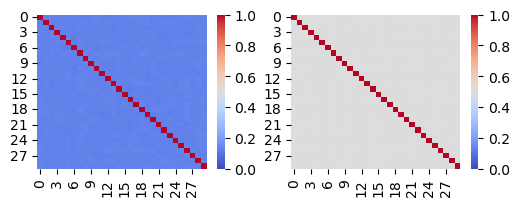

<Axes: >

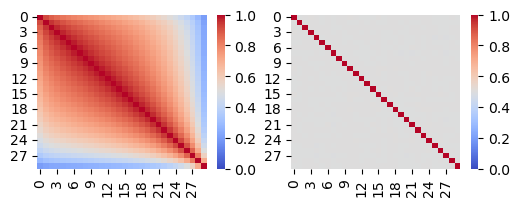

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns  # only for a nicer heatmap; if you'd like, you can use matplotlib's imshow

x_corr = np.corrcoef(toy_tops[...,0], rowvar=False)
y_corr = np.corrcoef(toy_tops[...,1], rowvar=False)

fig, ax = plt.subplots(1, 2, figsize=(6, 2))
sns.heatmap(x_corr, ax=ax[0], vmin=0., vmax=1, cmap="coolwarm")
sns.heatmap(y_corr, ax=ax[1], vmin=0., vmax=1, cmap="coolwarm")

plt.show()

idx = np.argsort(-toy_tops[...,0], axis=1)
_toy_tops = np.take_along_axis(toy_tops, idx[:, :, None], axis=1)

x_corr_ord = np.corrcoef(_toy_tops[...,0], rowvar=False)
y_corr_ord = np.corrcoef(_toy_tops[..., 1], rowvar=False)

fig, ax = plt.subplots(1, 2, figsize=(6, 2))

sns.heatmap(x_corr_ord, ax=ax[0], vmin=0., vmax=1, cmap="coolwarm")
sns.heatmap(y_corr_ord, ax=ax[1], vmin=0., vmax=1, cmap="coolwarm")


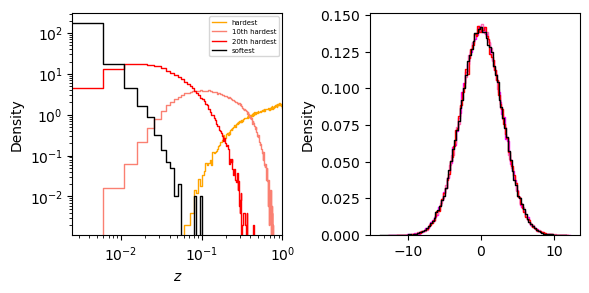

In [32]:
bins = np.arange(0.001, 1, 0.005)

from math import pi
import matplotlib.pyplot as plt
import seaborn as sns

# Plot 1: Histograms for x and y (flattened across all clouds)
first = _toy_tops[...,0][:,0]
tenth = _toy_tops[...,0][:,10]
twintieth = _toy_tops[...,0][:, 20]
last = _toy_tops[...,0][:,-1]

fig, ax = plt.subplots(1, 2, figsize=(6, 3))

plt.subplot(1, 2, 1)
sns.histplot(first, bins=bins, fill=False, color='orange', lw=1, label='hardest', element='step', stat='density')
sns.histplot(tenth, bins=bins, fill=False, color='salmon', lw=1, label='10th hardest', element='step', stat='density')
sns.histplot(twintieth, bins=bins, fill=False, color='red', lw=1, label='20th hardest', element='step', stat='density')
sns.histplot(last, bins=bins, fill=False, color='k', lw=1, label='softest', element='step', stat='density')

# Plot 1: Histograms for x and y (flattened across all clouds)
first = _toy_tops[...,1][:,0]
tenth = _toy_tops[...,1][:,10]
twentyeth = _toy_tops[...,1][:, 20]
last = _toy_tops[...,1][:,-1]

# ax[0].plot(np.linspace(0, 1, 100), 1/np.linspace(0, 1, 100), color='k',ls='--', lw=0.7, label=r'$1/z$')

sns.histplot(first, ax=ax[1], bins=100, fill=False, color='magenta', lw=1, label='hardest', element='step', stat='density')
sns.histplot(tenth, ax=ax[1], bins=100, fill=False, color='hotpink', lw=1, label='10th hardest', element='step', stat='density')
sns.histplot(twentyeth, ax=ax[1], bins=100, fill=False, color='red', lw=1, label='20th hardest', element='step', stat='density')
sns.histplot(last, ax=ax[1], bins=100, fill=False, color='k', lw=1, label='softest', element='step', stat='density')

# add plot for 1/

ax[0].set_xlabel(r'$z$')

plt.xscale('log')
plt.yscale('log')

plt.xlim(0.0025, 1.)
#add legend
ax[0].legend(loc='upper right', fontsize=5)
plt.tight_layout()
plt.show()

/var/folders/qf/b744x74x1633_slts1tp1w800000gn/T/ipykernel_72547/204329572.py:138: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr, 1/fpr, label=f'AUC NP = {roc_auc:.2f}')
/var/folders/qf/b744x74x1633_slts1tp1w800000gn/T/ipykernel_72547/204329572.py:139: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr_classifier, 1/fpr_classifier, label=f'AUC flow-matching {roc_aus_classifier:.2f}')


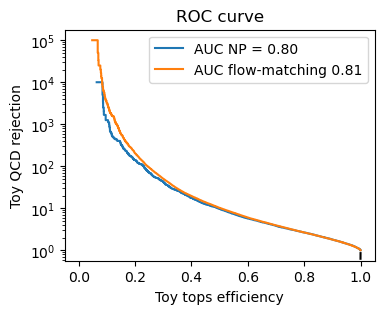

In [21]:
import numpy as np
from scipy.integrate import quad
from scipy.special import gammaln, gamma
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# ---------- Model log-likelihood functions ----------

def log_py(ys, sigma):
    # Computes log p(y) from the marginal over the latent mean.
    # Assume y_i ~ N(mu_lat,1) with mu_lat ~ N(0, sigma^2), mu=0.
    D = len(ys)
    term1 = -0.5 * D * np.log(2*np.pi)
    term2 = -0.5 * np.log(1 + D*sigma**2)
    sum_y = np.sum(ys)
    sum_y2 = np.sum(ys**2)
    term3 = -0.5 * (sum_y2 - (sum_y**2)/(D + 1/sigma**2))
    return term1 + term2 + term3

def log_px(xs, a):
    """
    Computes the log marginal likelihood for the x-data,
    where for a given sample of D x-values:
    
      x_i ~ Beta(0.5, 1+alpha)   with likelihood:
         p(x|alpha) = (Gamma(1.5+alpha)/(Gamma(0.5)*Gamma(1+alpha))) * x^(-0.5)*(1-x)^(alpha)
         
    and
      alpha ~ Gamma(a,1)   with density:  p(alpha)=alpha^(a-1)*exp(-alpha)/Gamma(a)
      
    We define:
         S = sum_i ln(1-x_i)
    and there is an extra constant from the x^(-0.5) factors.
    """
    D = len(xs)
    const = -0.5 * np.sum(np.log(xs)) - D * np.log(np.sqrt(np.pi))  # using Gamma(0.5)=sqrt(pi)
    S = np.sum(np.log(1-xs))
    
    # Define the integrand in alpha:

    def integrand(alpha):
        log_ratio = gammaln(1.5 + alpha) - gammaln(1+alpha)
        return (alpha**(a-1) * np.exp(-alpha*(1 - S)) * np.exp(D*log_ratio)) / gamma(a)
    
    val, err = quad(integrand, 0, np.inf, limit=100)
    return const + np.log(val)

def log_likelihood_sample(sample, a, sigma):
    """
    Given a sample of shape (D,2) with columns: x, y,
    compute the overall log likelihood:
      log p(x,y) = log p(y) + log p(x)
    using hyperparameter a for the Gamma prior for alpha and sigma for y.
    (Here we assume mu=0 for simplicity.)
    """
    xs = sample[:,0]
    ys = sample[:,1]
    return log_py(ys, sigma) + log_px(xs, a)

# ---------- Generate data (as provided) ----------

def generate_point_clouds(N, D, a, mu, sigma):
    samples = np.zeros((N, D, 2))
    for i in range(N):

        # Sample the latent parameters from priors
        alpha = np.random.gamma(shape=a, scale=1)  # note: np.random.gamma uses scale = 1/rate
        mean = np.random.normal(loc=mu, scale=sigma)
         
        for j in range(D):
            x = np.random.beta(0.5, 1 + alpha)
            y = np.random.normal(loc=mean, scale=1.0)
            samples[i, j, 0] = x
            samples[i, j, 1] = y
        
        sort_indices = np.argsort(-samples[i, :, 0])
        samples[i] = samples[i, sort_indices]
        
    return samples

# Hyperparameter settings for two models
# toy_qcd and toy_tops
N_samples = 10000   # Use a moderate number for demonstration (increase if needed)
D = 30

# Model hyperparameters: (a, mu, sigma)
params_qcd = (1, 0.0, 1)
params_tops = (2, 0.0, 2)

# Generate datasets (each sample is a point cloud of shape (D,2))
data_qcd = generate_point_clouds(N_samples, D, *params_qcd)
data_tops = generate_point_clouds(N_samples, D, *params_tops)

# ---------- Compute log likelihoods under each model ----------

# For each sample, compute log likelihood under the QCD model and the tops model.
# Here we assume that when evaluating a given model, we use its hyperparameters.
logL_qcd = np.zeros(N_samples)
logL_tops = np.zeros(N_samples)

for i in range(N_samples):
    logL_qcd[i] = log_likelihood_sample(data_qcd[i], params_qcd[0], params_qcd[2])
    logL_tops[i] = log_likelihood_sample(data_qcd[i], params_tops[0], params_tops[2])
    
# For the "toy_tops" dataset, do similarly:
logL_qcd_tops = np.zeros(N_samples)
logL_tops_tops = np.zeros(N_samples)

for i in range(N_samples):
    logL_qcd_tops[i] = log_likelihood_sample(data_tops[i], params_qcd[0], params_qcd[2])
    logL_tops_tops[i] = log_likelihood_sample(data_tops[i], params_tops[0], params_tops[2])

# Now, for each sample we can compute the log likelihood ratio:
# For a given sample, the log likelihood ratio is: LLR = log p(x,y|tops) - log p(x,y|qcd)
# We form scores for all samples in both datasets.
LLR_qcd = logL_tops - logL_qcd    # for samples from toy_qcd (expected to be lower)
LLR_tops = logL_tops_tops - logL_qcd_tops  # for samples from toy_tops (expected to be higher)

# # ---------- Compute ROC curve ----------

# Labels: let 1 = tops (signal), 0 = qcd (background)
scores = np.concatenate([LLR_tops, LLR_qcd])
labels = np.concatenate([np.ones(N_samples), np.zeros(N_samples)])

# Ian's classifier results
dat = np.load('tpr_fpr_values.npz')
tpr_classifier = dat['tpr']
fpr_classifier = dat['fpr']

# Compute ROC curve and AUC
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(labels, scores)
roc_auc = auc(fpr, tpr)
roc_aus_classifier = auc(fpr_classifier, tpr_classifier)

plt.figure(figsize=(4,3))
plt.plot(tpr, 1/fpr, label=f'AUC NP = {roc_auc:.2f}')
plt.plot(tpr_classifier, 1/fpr_classifier, label=f'AUC flow-matching {roc_aus_classifier:.2f}')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('Toy tops efficiency')
plt.ylabel('Toy QCD rejection')
plt.title('ROC curve')
plt.legend()
plt.yscale('log')

plt.show()


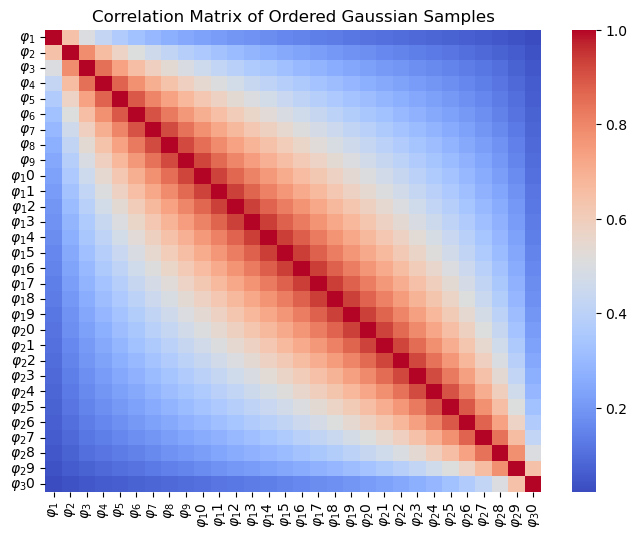

In [75]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns  # only for a nicer heatmap; if you'd like, you can use matplotlib's imshow

# Parameters
M = 30       # number of samples per block (order statistics positions)
N = 100000   # number of blocks (independent trials)

# Generate N blocks of M independent Gaussian samples
mu, sigma = 0, 1  # parameters of the Gaussian distribution
data = np.random.normal(mu, sigma, size=(N, M))

# Sort each block in decreasing order (from max to min)
data = -np.sort(-data, axis=1)


# Compute the correlation matrix among the M positions
correlation_matrix = np.corrcoef(data, rowvar=False)

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, cmap="coolwarm", 
            xticklabels=[rf"$\varphi_{i+1}$" for i in range(M)], 
            yticklabels=[rf"$\varphi_{i+1}$" for i in range(M)])
plt.title("Correlation Matrix of Ordered Gaussian Samples")
plt.show()


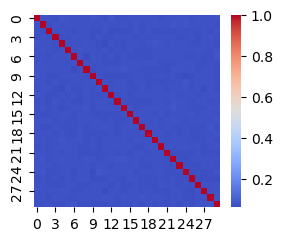

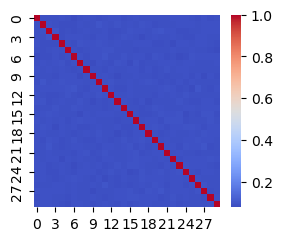

In [110]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns  # only for a nicer heatmap; if you'd like, you can use matplotlib's imshow

correlation_matrix = np.corrcoef(toy_qcd[...,0], rowvar=False)
# correlation_matrix = np.corrcoef(-np.sort(-toy_qcd[...,0], axis=1), rowvar=False)

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(3, 2.5))
sns.heatmap(correlation_matrix, cmap="coolwarm")
plt.show()

correlation_matrix = np.corrcoef(toy_tops[...,0], rowvar=False)
# correlation_matrix = np.corrcoef(-np.sort(-toy_tops[...,0], axis=1), rowvar=False)

plt.figure(figsize=(3, 2.5))
sns.heatmap(correlation_matrix, cmap="coolwarm")
plt.show()

In [173]:
-np.sort(-np.array([23.5,4,45,3,354]))

array([354. ,  45. ,  23.5,   4. ,   3. ])

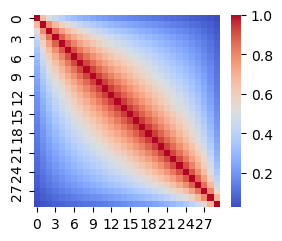

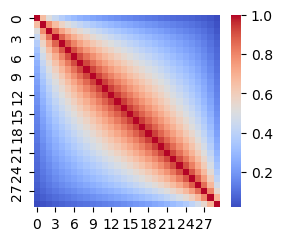

In [114]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns  # only for a nicer heatmap; if you'd like, you can use matplotlib's imshow

# correlation_matrix = np.corrcoef(very_toy_qcd[...,0], rowvar=False)
correlation_matrix = np.corrcoef(-np.sort(-very_toy_qcd[...,0], axis=1), rowvar=False)

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(3, 2.5))
sns.heatmap(correlation_matrix, cmap="coolwarm")
plt.show()

# correlation_matrix = np.corrcoef(very_toy_tops[...,0], rowvar=False)
correlation_matrix = np.corrcoef(-np.sort(-very_toy_tops[...,0], axis=1), rowvar=False)

plt.figure(figsize=(3, 2.5))
sns.heatmap(correlation_matrix, cmap="coolwarm")
plt.show()

In [80]:
toy_qcd[...,0].shape

(100000, 30)

Number of pairs with x_(1) in [ -0.05 , 0.05 ]: 40182


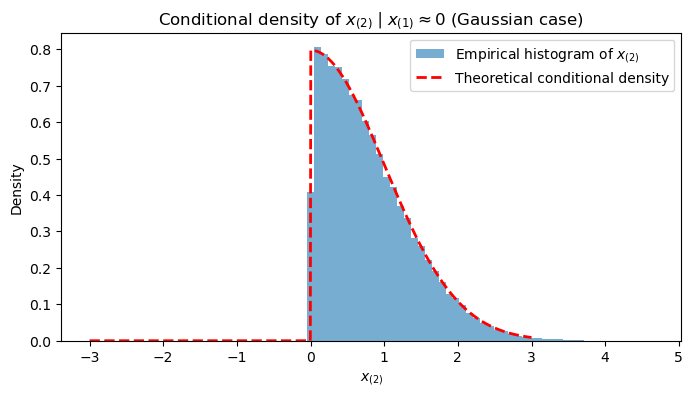

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Number of pairs to generate
N = 1000000

# Generate N pairs of i.i.d. standard Gaussian samples.
data = np.random.randn(N, 2)

# Sort each pair to obtain order statistics:
# data_sorted[:,0] is the minimum (x_(1)) and data_sorted[:,1] is the maximum (x_(2)).
data_sorted = np.sort(data, axis=1)

# Condition on the minimum being close to u_target = 0.
u_target = 0.0
tol = 0.05  # tolerance for x_(1)
mask = (data_sorted[:, 0] > u_target - tol) & (data_sorted[:, 0] < u_target + tol)
filtered = data_sorted[mask]

print("Number of pairs with x_(1) in [", u_target - tol, ",", u_target + tol, "]:", len(filtered))

# Plot histogram of x_(2) for the filtered pairs.
plt.figure(figsize=(8, 4))
plt.hist(filtered[:, 1], bins=50, density=True, alpha=0.6, label='Empirical histogram of $x_{(2)}$')

# Theoretical conditional density for x_(2) given x_(1)=0:
# p(x_(2)|x_(1)=0) = 2*phi(x_(2)) for x_(2) >= 0 and 0 for x_(2) < 0.
x_vals = np.linspace(-3, 3, 1000)
phi_vals = norm.pdf(x_vals)  # The standard Gaussian PDF.
theoretical_density = np.where(x_vals >= u_target, 2 * phi_vals, 0)

plt.plot(x_vals, theoretical_density, 'r--', linewidth=2, label='Theoretical conditional density')
plt.xlabel('$x_{(2)}$')
plt.ylabel('Density')
plt.title('Conditional density of $x_{(2)} \\mid x_{(1)} \\approx 0$ (Gaussian case)')
plt.legend()
plt.show()


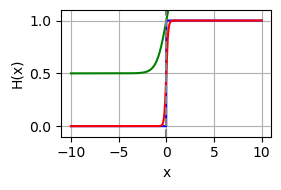

In [141]:
import numpy as np
import matplotlib.pyplot as plt

# Define x values
x = np.linspace(-10, 10, 1000)

# Heaviside function
heaviside = np.heaviside(x, 0.5)  # 0.5 value at x=0 for symmetry

# Sigmoid function

L=10

sigmoid = 1 / (1 + np.exp(-x*L))
# almost_sigmoid = 1 + np.exp(-x)

# Plotting
plt.figure(figsize=(3, 2))

# Heaviside plot
plt.subplot(1, 1, 1)
plt.plot(x, heaviside, label='Heaviside Step', color='blue')
plt.plot(x, sigmoid, label='Sigmoid', color='red')
plt.plot(x, almost_sigmoid, label='Almost Sigmoid', color='green')
plt.xlabel('x')
plt.ylabel('H(x)')
plt.grid(True)
plt.ylim(-0.1, 1.1)
plt.axvline(0, color='gray', linestyle='--')

plt.tight_layout()
plt.show()


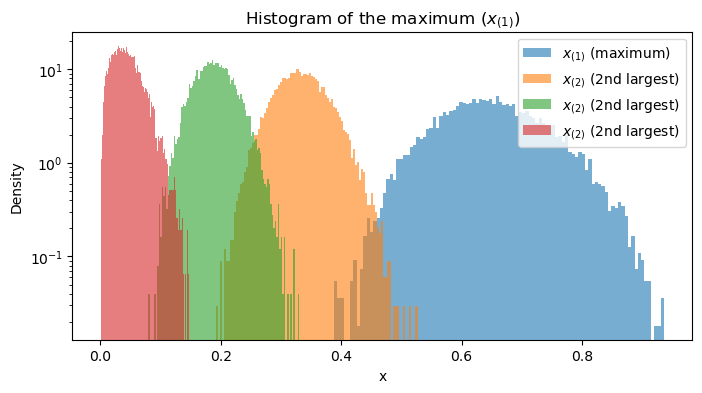

In [154]:
# import numpy as np
# import scipy.stats as stats
# import matplotlib.pyplot as plt

# # Beta distribution parameters:
# a = 2.0
# b = 5.0
# M = 30  # Number of points in each set (point cloud)

# # SciPy's beta distribution provides cdf and ppf.
# def beta_cdf(x):
#     return stats.beta.cdf(x, a, b)

# def beta_ppf(q):
#     return stats.beta.ppf(q, a, b)

# def sample_ordered_beta(M):
#     """
#     Autoregressive sampling of M points in decreasing order from Beta(a,b).
#     The largest (maximum) value is x_(1), the second largest is x_(2), etc.
#     """
#     # Sample U ~ Uniform(0,1) for the maximum:
#     U = np.random.uniform()
#     # The CDF of the maximum is F_max(x) = [F(x)]^M, so:
#     x1 = beta_ppf(U**(1.0/M))
#     ordered_points = [x1]
#     # Now sample the remaining points recursively:
#     for k in range(2, M+1):
#         # Number of points remaining:
#         remaining = M - k + 1
#         V = np.random.uniform()
#         # Given x_(k-1), the conditional CDF of the next maximum is:
#         # F(x_(k)) = F(x_(k-1)) * V^(1/remaining)
#         cond_q = beta_cdf(ordered_points[-1]) * (V**(1.0/remaining))
#         xk = beta_ppf(cond_q)
#         ordered_points.append(xk)
#     return ordered_points

# # Generate one sample of ordered Beta points
# ordered_sample = sample_ordered_beta(M)
# print("Ordered sample (in decreasing order):")
# print(ordered_sample)

# # Generate many samples and plot histograms for the first and second largest values.
# N_samples = 10000
# samples = np.array([sample_ordered_beta(M) for _ in range(N_samples)])

plt.figure(figsize=(8, 4))
plt.hist(samples[:, 0], bins=100, density=True, alpha=0.6, label=r'$x_{(1)}$ (maximum)')
plt.hist(samples[:, 10], bins=100, density=True, alpha=0.6, label=r'$x_{(2)}$ (2nd largest)')
plt.hist(samples[:, 20], bins=100, density=True, alpha=0.6, label=r'$x_{(2)}$ (2nd largest)')
plt.hist(samples[:, -1], bins=100, density=True, alpha=0.6, label=r'$x_{(2)}$ (2nd largest)')

plt.xlabel('x')
plt.ylabel('Density')
plt.title('Histogram of the maximum ($x_{(1)}$)')
plt.legend()
plt.yscale('log')

plt.show()


Ordered sample (in decreasing order):
[0.4731880634545216, 0.23426877430713894, 0.17997551576374113, 0.06213168296865021, 0.028788826451416012]


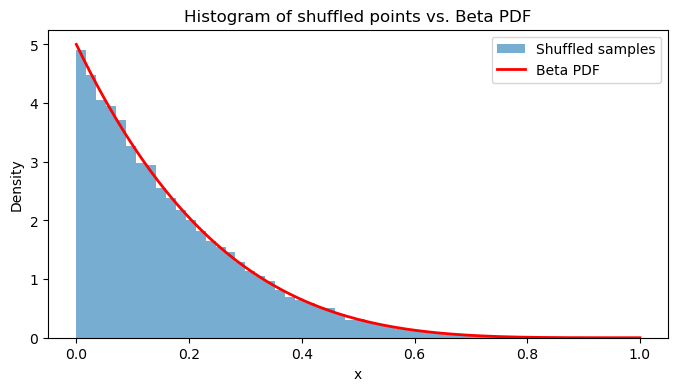

In [161]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

# Beta distribution parameters
a = 1.0
b = 5.0
n = 5  # Number of points in each set

# Define Beta CDF and PPF functions using SciPy
beta_cdf = lambda x: stats.beta.cdf(x, a, b)
beta_ppf = lambda q: stats.beta.ppf(q, a, b)

def sample_maximum():
    """
    Sample the maximum (largest value) from n i.i.d. Beta(a,b) variables.
    The CDF of the maximum is F_max(x) = [F(x)]^n.
    """
    U = np.random.uniform()
    # Inverse transform: F(x_max) = U^(1/n)
    q = U**(1.0/n)
    x_max = beta_ppf(q)
    return x_max

def sample_conditional(x_prev, k):
    """
    Given that the (k-1)th order statistic (in decreasing order) is x_prev,
    sample the kth order statistic from the remaining n-k+1 points.
    The conditional CDF is:
        P(x <= x_{(k)} | x_{(k-1)} = x_prev) = [F(x)/F(x_prev)]^(n-k+1), for x <= x_prev.
    """
    remaining = n - k + 1
    V = np.random.uniform()
    q = beta_cdf(x_prev) * (V**(1.0/remaining))
    x_k = beta_ppf(q)
    return x_k

def sample_ordered_beta():
    """
    Generate an ordered set of n points from Beta(a,b) in decreasing order.
    """
    ordered = []
    # Sample the maximum
    x1 = sample_maximum()
    ordered.append(x1)
    # For k=2,...,n, sample the kth order statistic given the previous
    for k in range(2, n+1):
        xk = sample_conditional(ordered[-1], k)
        ordered.append(xk)
    return ordered

# Generate one ordered sample
ordered_sample = sample_ordered_beta()
print("Ordered sample (in decreasing order):")
print(ordered_sample)

# Cross-check: generate many samples and then shuffle each set.
N_samples = 10000
ordered_samples = np.array([sample_ordered_beta() for _ in range(N_samples)])
# Shuffle each set (i.e. random permutation) to recover the unordered set
shuffled_samples = np.array([np.random.permutation(sample) for sample in ordered_samples])
all_shuffled = shuffled_samples.flatten()

# Plot histogram of shuffled samples
plt.figure(figsize=(8, 4))
plt.hist(all_shuffled, bins=50, density=True, alpha=0.6, label='Shuffled samples')
# Plot the theoretical Beta PDF
x_vals = np.linspace(0, 1, 1000)
beta_pdf = stats.beta.pdf(x_vals, a, b)
plt.plot(x_vals, beta_pdf, 'r-', linewidth=2, label='Beta PDF')
plt.xlabel('x')
plt.ylabel('Density')
plt.title('Histogram of shuffled points vs. Beta PDF')
plt.legend()
plt.show()


In [160]:
samples[2]

array([0.67385774, 0.56203758, 0.51272627, 0.50952688, 0.5033907 ,
       0.46341367, 0.45676185, 0.43202566, 0.4285743 , 0.41876801,
       0.39444627, 0.36872864, 0.3497379 , 0.32473207, 0.31828685,
       0.30942526, 0.30367752, 0.30201042, 0.28976646, 0.28880319,
       0.2808684 , 0.26382407, 0.26200321, 0.24680076, 0.21707348,
       0.20840178, 0.19521172, 0.17697804, 0.12100056, 0.08046367])

In [162]:
import numpy as np
import math

# Parameters
beta_param = 2.0  # parameter for Beta(beta, 1)
M = 5             # number of points per sample
lam = 0.01        # smoothing parameter for the sigmoid

# Define the Beta(beta, 1) PDF on [0,1]
def beta_pdf(x, beta_param):
    # Beta(beta,1) pdf: beta * x^(beta-1) for x in [0,1]
    return beta_param * (x ** (beta_param - 1)) if 0 <= x <= 1 else 0

# Define the sigmoid function
def sigmoid(u):
    return 1.0 / (1.0 + np.exp(-u))

# Define the regularized density f_lambda.
# Note: Here, the inputs are assumed to be in the desired ordering.
# Since we're not enforcing ordering, this density is defined over [0,1]^M.
def f_lambda(xs, beta_param, lam):
    # xs is an array of length M
    M_factorial = math.factorial(M)
    prod_pdf = np.prod([beta_pdf(x, beta_param) for x in xs])
    prod_sigmoid = 1.0
    for j in range(M-1):
        # For each adjacent pair, compute the sigmoid of (x[j+1]-x[j])/lam.
        prod_sigmoid *= sigmoid((xs[j+1] - xs[j]) / lam)
    return M_factorial * prod_pdf * prod_sigmoid

# Define the proposal density: uniform on [0,1]^M (which is 1)
def g(xs):
    # xs in [0,1]^M, density is 1
    return 1.0

# Choose the constant C such that f_lambda(xs) <= C for all xs in [0,1]^M.
# We have: f_lambda(xs) <= M! * (beta)^M.
C = math.factorial(M) * (beta_param ** M)

# Rejection sampling function for a single sample.
def rejection_sample(beta_param, lam, M, C):
    while True:
        # Sample from the proposal: uniformly from [0,1]^M.
        xs = np.random.uniform(0, 1, M)
        # Evaluate the unnormalized target density at xs.
        f_val = f_lambda(xs, beta_param, lam)
        # Draw u ~ Uniform(0,1)
        u = np.random.uniform(0, 1)
        if u <= f_val / C:
            return xs

# Generate one sample.
sample = rejection_sample(beta_param, lam, M, C)
print("Accepted sample (not necessarily in order):")
print(sample)

# Optionally, if you want samples that respect the ordering, you can enforce it:
def enforce_order(xs):
    return np.sort(xs)  # sorts in increasing order

# Generate an ordered sample by rejecting samples that violate order.
def rejection_sample_ordered(beta_param, lam, M, C):
    while True:
        xs = rejection_sample(beta_param, lam, M, C)
        # Check if the ordering condition holds: we want x[0] <= x[1] <= ... <= x[M-1].
        if np.all(np.diff(xs) >= 0):
            return xs

ordered_sample = rejection_sample_ordered(beta_param, lam, M, C)
print("Accepted ordered sample (in increasing order):")
print(ordered_sample)

# If you want a decreasing order, you can simply reverse the order:
decreasing_sample = ordered_sample[::-1]
print("Accepted ordered sample (in decreasing order):")
print(decreasing_sample)


Accepted sample (not necessarily in order):
[0.40757131 0.60722475 0.80693177 0.87618035 0.96567165]
Accepted ordered sample (in increasing order):
[0.57568508 0.67933722 0.93261807 0.94480568 0.95874877]
Accepted ordered sample (in decreasing order):
[0.95874877 0.94480568 0.93261807 0.67933722 0.57568508]


In [163]:
import numpy as np
from scipy.stats import beta
from scipy.integrate import quad
import matplotlib.pyplot as plt

# Parameters for the Beta density
alpha = 2.0   # shape parameter alpha (set as desired)
beta_param = 5.0   # shape parameter beta (set as desired)

# Number of ordered points per event
N = 30

# Lambda parameter in the model (deformation parameter)
# You can change lam to other positive values.
lam = 0.5  # for example; note that 1/lam appears in the exponents

# --- Helper functions ---

def p(x, a=alpha, b=beta_param):
    """Base density: Beta PDF on [0,1]."""
    return beta.pdf(x, a, b)

def P(x, a=alpha, b=beta_param):
    """Cumulative distribution function of the Beta density."""
    return beta.cdf(x, a, b)

def target_density(x, x_prev, n, N, lam, a=alpha, b=beta_param):
    """
    Unnormalized target density for x given the previous sample x_prev,
    corresponding to index n (n = 1,..., N) in the ordered sequence.
    
    For n=1, x_prev is ignored.
    
    The density is defined on x in [0, 1].
    
    q(x | x_prev) ∝ [1 - exp(-1/lam)*P(x)]^(n-1) * [P(x)]^(N-n) 
                      * p(x) / (1+ exp(-1/lam*(x - x_prev))).
    
    For n=1 the extra term [1 - exp(-1/lam)*P(x)]^(0) = 1, and
    the denominator becomes 1+ exp(-1/lam*(x - x_prev)) but x_prev is not used.
    """
    # Ensure x is within [0,1]:
    if x < 0 or x > 1:
        return 0.0

    # Extra factor:
    if n == 1:
        extra_factor = 1.0
    else:
        extra_factor = (1 - np.exp(-1.0/lam) * P(x))**(n-1)
    
    # Ordering kernel: we require x to be "less than" x_prev if ordered in decreasing order.
    # Here note: If the ordering is such that x_[1] is max, then we require x_[2] <= x_[1].
    # In the model, the smoothing factor is 1/(1+exp(-1/lam*(x-x_prev))).
    # (For n==1, x_prev is not used.)
    if n == 1:
        order_factor = 1.0
    else:
        order_factor = 1.0/(1.0 + np.exp(-1.0/lam*(x - x_prev)))
    
    # Factor from the base Beta density and the factor P(x)^(N-n)
    result = extra_factor * (P(x)**(N - n)) * p(x) * order_factor
    return result

def normalization(x_prev, n, N, lam, a=alpha, b=beta_param):
    """
    Compute the normalization constant Z_n(lam, x_prev) =
    \int_0^1 target_density(x, x_prev, n, N, lam) dx.
    """
    Z, err = quad(lambda x: target_density(x, x_prev, n, N, lam, a, b), 0, 1)
    return Z

def conditional_density(x, x_prev, n, N, lam, a=alpha, b=beta_param):
    """
    The normalized conditional density q^\lambda(x|x_prev) for the n-th ordered point.
    """
    Z = normalization(x_prev, n, N, lam, a, b)
    return target_density(x, x_prev, n, N, lam, a, b) / Z if Z > 0 else 0.0

def sample_conditional(x_prev, n, N, lam, a=alpha, b=beta_param, max_iter=10000):
    """
    Sample from the conditional q^\lambda(x| x_prev) using rejection sampling.
    We use the Beta(a, b) density as the proposal distribution.
    """
    # Compute (approximate) maximum ratio by evaluating on a grid.
    xs = np.linspace(0, 1, 1000)
    target_vals = np.array([target_density(x, x_prev, n, N, lam, a, b) for x in xs])
    proposal_vals = beta.pdf(xs, a, b)
    # Avoid dividing by zero:
    ratio = np.divide(target_vals, proposal_vals, out=np.zeros_like(target_vals), where=proposal_vals>0)
    M = np.max(ratio) * 1.1  # add 10% safety margin

    # Rejection sampling loop.
    for _ in range(max_iter):
        # Sample x_proposal from Beta(a,b)
        x_prop = beta.rvs(a, b)
        # Compute acceptance probability.
        t = target_density(x_prop, x_prev, n, N, lam, a, b)
        q_prop = beta.pdf(x_prop, a, b)
        if q_prop == 0:
            continue
        accept_prob = t / (M * q_prop)
        if np.random.rand() < accept_prob:
            return x_prop

    # In case no sample is accepted (unlikely), return None.
    return None

def sample_ordered_event(N, lam, a=alpha, b=beta_param):
    """
    Sample one event of N ordered points x_[1], ..., x_[N].
    
    Here we assume that the ordering is such that:
      x_[1] is the maximum,
      and for n >= 2, x_[n] is sampled conditionally given x_[n-1].
    
    We use our conditional density defined above.
    """
    xs = np.zeros(N)
    # Sample x1 from the "marginal" density for n = 1 (x_prev is not used).
    # In our model, for n=1 the density is proportional to P(x)^(N-1)*p(x).
    # Note: the true density for the maximum of N independent samples from Beta(a,b)
    # is: f_{max}(x) = N * p(x) * [P(x)]^(N-1). Our model has no explicit constant,
    # so the rejection sampler will take care of normalization.
    xs[0] = sample_conditional(0.0, 1, N, lam, a, b)
    # For subsequent points, pass the previous sampled value.
    for n in range(2, N+1):
        xs[n-1] = sample_conditional(xs[n-2], n, N, lam, a, b)
    return xs

# --- Main sampling procedure ---
def main_sample(num_events=10000, N=30, lam=lam, a=alpha, b=beta_param):
    events = []
    for i in range(num_events):
        ev = sample_ordered_event(N, lam, a, b)
        if ev is not None:
            events.append(ev)
    return np.array(events)

# Example usage:
if __name__ == '__main__':
    num_events = 10000  # for example
    N = 30              # each event has 30 ordered points
    lam = 0.5           # try various values (e.g. 0.1, 0.5, 1.0)
    alpha = 2.0         # Beta shape parameter alpha
    beta_param = 5.0    # Beta shape parameter beta

    samples = main_sample(num_events, N, lam, alpha, beta_param)
    print("Shape of sample array:", samples.shape)
    
    # As an illustration, plot the histogram of the first and second ordered variables.
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.hist(samples[:, 0], bins=50, density=True)
    plt.title("Histogram of x_[1] (maximum)")
    plt.subplot(1, 2, 2)
    plt.hist(samples[:, 1], bins=50, density=True)
    plt.title("Histogram of x_[2]")
    plt.show()


KeyboardInterrupt: 